<a href="https://colab.research.google.com/github/dasarpai/google-gemini-cookbook/blob/main/examples/Anomaly_detection_with_embeddings-Hari-Runs-Fully.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Anomaly detection with embeddings

<table align="left">
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Anomaly_detection_with_embeddings.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Overview

This tutorial demonstrates how to use the embeddings from the Gemini API to detect potential outliers in your dataset. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and detect outliers outside a particular radius of the central point of each categorical cluster.


In [1]:
!pip install -U -q google-generativeai

In [2]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import google.generativeai as genai

# Used to securely store your API key
from google.colab import userdata

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

## Prepare dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html){:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. This tutorial uses the training subset.

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [4]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [5]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

# Cut off each text entry after 5,000 characters
newsgroups_train.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroups_train.data]

In [6]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, sample some of the data by taking 150 data points in the training dataset and choosing a few categories. This tutorial uses the science categories.

In [7]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 25 #150 #To reduce the experiment cost I am reducing this number.
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train

,index,Text,Label,Class Name
0,275,Re: Fifth Amendment and Passwords\nOrganizati...,11,sci.crypt
1,276,Re: MacPGP 2.2 Source Problems\nOrganization:...,11,sci.crypt
2,277,Re: Fifth Amendment and Passwords\nOrganizati...,11,sci.crypt
3,278,Clipper considered harmful\nOrganization: Opt...,11,sci.crypt
4,279,Re: text of White House announcement and Q&As...,11,sci.crypt
...,...,...,...,...
95,370,Nasa incentives\nX-Added: Forwarded by Space ...,14,sci.space
96,371,"Re: Sunrise/ sunset times\nOrganization: NAS,...",14,sci.space
97,372,Re: space food sticks\nKeywords: food\nLines:...,14,sci.space
98,373,Re: How many read sci.space?\nOrganization: T...,14,sci.space


In [8]:
df_train['Class Name'].value_counts()

,count
Class Name,
sci.crypt,25
sci.electronics,25
sci.med,25
sci.space,25


## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the Gemini API.

### API changes to Embeddings with model embedding-001

For the new embeddings model, embedding-001, there is a new task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [ ]:
API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=API_KEY)

In [11]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")['embedding']
    return np.array(embedding)

  return embed_fn

def create_embeddings(df):
  model = 'models/embedding-001'
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(df_train)
df_train.drop('index', axis=1, inplace=True)

  0%|          | 0/100 [00:00<?, ?it/s]

## Dimensionality reduction

The dimension of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [12]:
len(df_train['Embeddings'][0])

768

In [13]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(100, 768)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) approach to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

In [17]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,-4.676595,4.467921,sci.crypt
1,-8.728280,1.246734,sci.crypt
2,-4.765857,4.500941,sci.crypt
3,-6.087115,-0.066621,sci.crypt
4,-5.129967,1.660207,sci.crypt
...,...,...,...
95,0.159096,-0.724774,sci.space
96,5.358096,-2.415894,sci.space
97,3.505988,-5.534242,sci.space
98,2.223311,-1.618823,sci.space


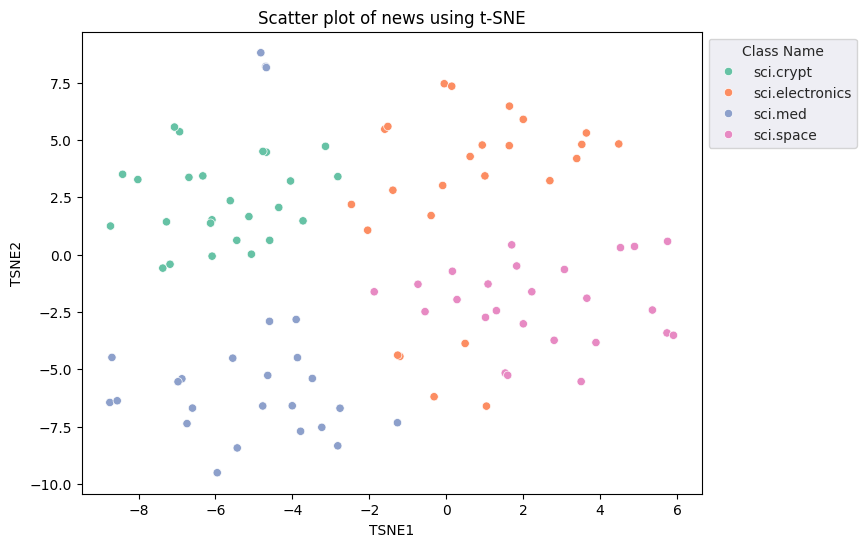

In [18]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

## Outlier detection

To determine which points are anomalous, you will determine which points are inliers and outliers. Start by finding the centroid, or location that represents the center of the cluster, and use the distance to determine the points that are outliers.

Start by getting the centroid of each category.

In [19]:
def get_centroids(df_tsne):
  # Get the centroid of each cluster
  centroids = df_tsne.groupby('Class Name').mean()
  return centroids

centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
sci.crypt,-5.826895,2.324448
sci.electronics,0.596451,2.524497
sci.med,-5.097330,-4.451097
sci.space,2.426909,-2.136958


In [20]:
def get_embedding_centroids(df):
  emb_centroids = dict()
  grouped = df.groupby('Class Name')
  for c in grouped.groups:
    sub_df = grouped.get_group(c)
    # Get the centroid value of dimension 768
    emb_centroids[c] = np.mean(sub_df['Embeddings'], axis=0)

  return emb_centroids

In [21]:
emb_c = get_embedding_centroids(df_train)

Plot each centroid you have found against the rest of the points.

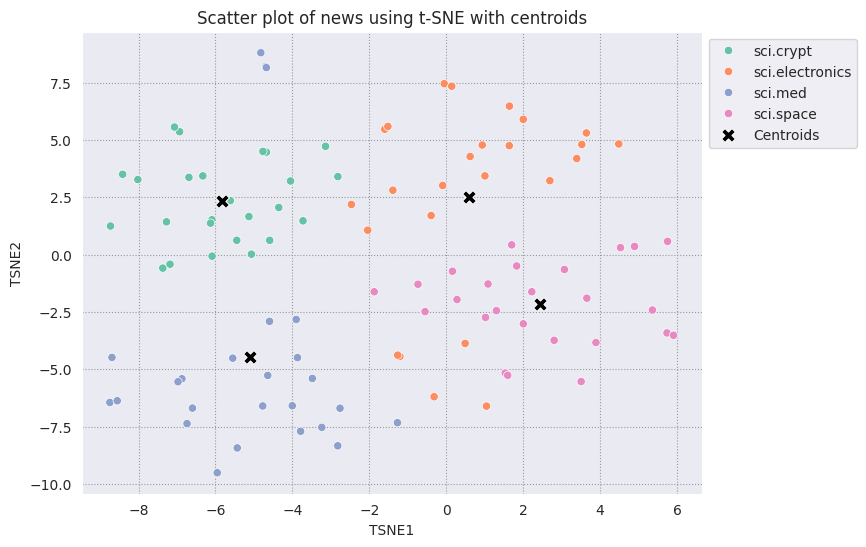

In [22]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Choose a radius. Anything beyond this bound from the centroid of that category is considered an outlier.

In [23]:
def calculate_euclidean_distance(p1, p2):
  return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
  for idx, row in df.iterrows():
    class_name = row['Class Name'] # Get class name of row
    # Compare centroid distances
    dist = calculate_euclidean_distance(row['Embeddings'],
                                        emb_centroids[class_name])
    df.at[idx, 'Outlier'] = dist > radius

  return len(df[df['Outlier'] == True])

In [24]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
  num_outliers.append(detect_outlier(df_train, emb_c, i))

<ipython-input-23-0090db075f78>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'Outlier'] = dist > radius


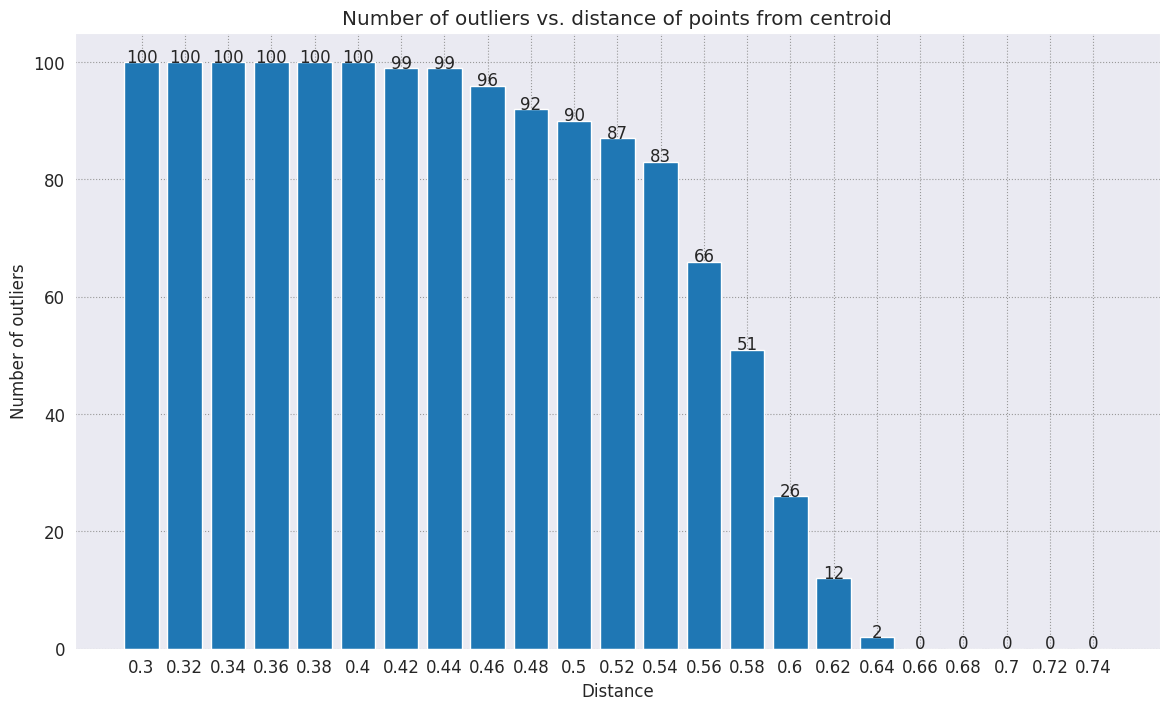

In [25]:
# Plot range_ and num_outliers
fig = plt.figure(figsize = (14, 8))
plt.rcParams.update({'font.size': 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
  plt.text(i, num_outliers[i], num_outliers[i], ha = 'center')

plt.show()

Depending on how sensitive you want your anomaly detector to be, you can choose which radius you would like to use. For now, 0.62 is used, but you can change this value.

In [26]:
# View the points that are outliers
RADIUS = 0.62
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train['Outlier'] == True]
df_outliers.head()

,Text,Label,Class Name,Embeddings,Outlier
26,"PADS model of a 68hc11.\nOrganization: DSG, S...",12,sci.electronics,"[-0.020915855, -0.03240435, -0.065267384, -0.0...",True
29,Re: How do DI boxes work?\nOrganization: cam....,12,sci.electronics,"[-0.026001584, -0.017287673, -0.023984024, 0.0...",True
44,RE: Exploding TV\nNntp-Posting-Host: engr.eng...,12,sci.electronics,"[-0.025938151, -0.055426367, 0.0011094777, -0....",True
46,\nDistribution: world\nOrganization: Chaos li...,12,sci.electronics,"[-0.003696999, -0.043310728, -0.06851728, -0.0...",True
50,Re: Altitude adjustment\nReply-To: \nOrganiza...,13,sci.med,"[0.002929472, 0.0022317795, -0.036673747, -0.0...",True


In [27]:
df_outliers.shape

(12, 5)

In [28]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers['Outlier'].index]

Plot the outliers and denote them using a transparent red color.

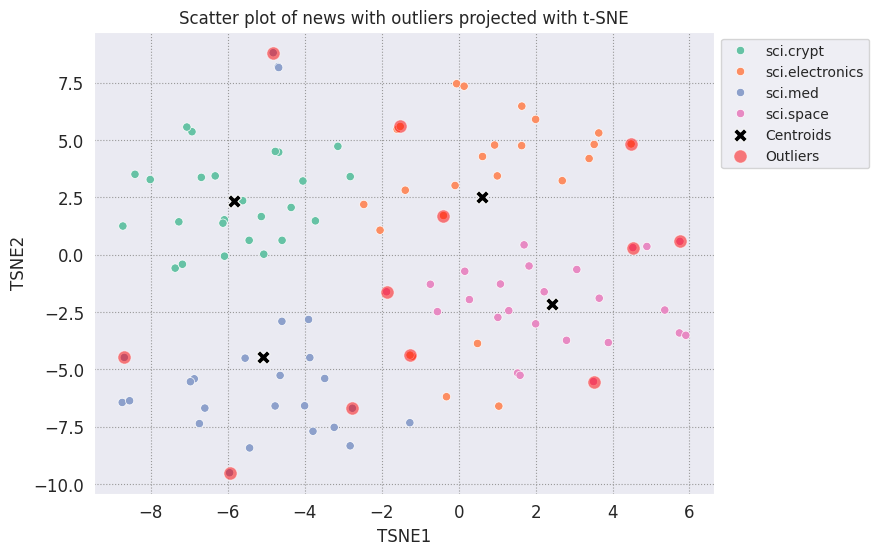

In [29]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# Draw a red circle around the outliers
sns.scatterplot(data=outliers_projected, x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Outliers')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Use the index values of the datafames to print a few examples of what outliers can look like in each category. Here, the first data point from each category is printed out. Explore other points in each category to see data that are deemed as outliers, or anomalies.

In [31]:
sci_crypt_outliers = df_outliers[df_outliers['Class Name'] == 'sci.crypt']
if not sci_crypt_outliers.empty:
    print(sci_crypt_outliers['Text'].iloc[0])
else:
    print("No outliers found for 'sci.crypt' class.")

No outliers found for 'sci.crypt' class.


In [32]:
sci_elec_outliers = df_outliers[df_outliers['Class Name'] == 'sci.electronics']
if not sci_elec_outliers.empty:
    print(sci_elec_outliers['Text'].iloc[0])
else:
    print("No outliers found for 'sci.electronics' class.")

 PADS model of a 68hc11.
Organization: DSG, Stanford University, CA 94305, USA
Lines: 5

Has anyone done a model of the 52 pin version of the 68hc11?  It doesn't
seem to be too big a job, but if someone else has already done it ...

many thanks
Ken Martin



In [33]:
sci_med_outliers = df_outliers[df_outliers['Class Name'] == 'sci.med']
if not sci_med_outliers.empty:
    print(sci_med_outliers['Text'].iloc[0])
else:
    print("No outliers found for 'sci.med' class.")

 Re: Altitude adjustment
Reply-To: 
Organization: NYNEX Science & Technology, Inc
Lines: 32



In article <>   writes:
>I live at sea-level, and am called-upon to travel to high-altitude cities
>quite frequently, on business.  The cities in question are at 7000 to 9000
>feet of altitude.  One of them especially is very polluted...

Mexico City, Bogota, La Paz?
>
>Often I feel faint the first two or three days.  I feel lightheaded, and
>my heart seems to pound a lot more than at sea-level.  Also, it is very
>dry in these cities, so I will tend to drink a lot of water, and keep
>away from dehydrating drinks, such as those containing caffeine or alcohol.
>

>Thing is, I still have symptoms.  How can I ensure that my short trips there
> are as comfortable as possible?
>Is there something else that I could do?

---

An unconventional remedy that you might try for altitude sickness in the Andes is
chewing coca leaves or taking teas made from coca leaves. You might notice that
many of the nat

In [34]:
sci_space_outliers = df_outliers[df_outliers['Class Name'] == 'sci.space']
if not sci_space_outliers.empty:
    print(sci_space_outliers['Text'].iloc[0])
else:
    print("No outliers found for 'sci.space' class.")

 RIMSAT, US/Russian joint venture
Organization: University of Illinois at Urbana
Lines: 121


I've been to three talks in the last month which might be of interest. I've 
transcribed some of my notes below.  Since my note taking ability is by no means
infallible, please assume that all factual errors are mine.  Permission is 
granted to copy this without restriction.

Michael Sternberg, Cheif of Operations of RIMSAT, was invited to speak at an
informal lunch held by ACDIS here on the campus of the University of Illinois.
ACDIS is an organization on campus that deals with Arms Control, Disarmament and
International Security.  RIMSAT was considered an appropriate topic because the
company is using Russian launchers and satellites.  I think it also helped that
his daughter is a grad student in the International Relations program.

The concept behind RIMSAT apparently began when Matt Neilson  went to Tonga
to visit a friend.  While he was there, he somehow ended up visiting the king,
who h

## Next steps

You've now created an anomaly detector using embeddings! Try using your own textual data to visualize them as embeddings, and choose some bound such that you can detect outliers. You can perform dimensionality reduction in order to complete the visualization step. Note that t-SNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).